<a href="https://colab.research.google.com/github/PHY041/SC3000-Cart-Pole/blob/main/SC3000_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Balancing a Pole on a Cart

#members and contribution
Pang Haoyang (U2110313A)
Pham The Binh Minh (U2222784E)
Contributed equally and combined our codes in the final submittion

## Installing dependencies:

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.5/821.5 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## Importing dependencies and define helper functions

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [4]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01327522 -0.02011352 -0.0243119  -0.01343203]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [8]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.01287294 -0.21487853 -0.02458054  0.27148214]
Reward for this step: 1.0
Is this round done? False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


In [10]:
#set the definition for the different parameters

Learning Rate (α): Determines to what extent newly acquired information overrides old information. A factor of 0 will make the agent not learn anything, while a factor of 1 would make the agent consider only the most recent information.

Discount Factor (γ): Determines the importance of future rewards. A factor of 0 will make the agent short-sighted by only considering current rewards, while a factor near 1 will make it strive for a long-term high reward.

Exploration Rate (ε): During the initial phase of learning, our agent should take random actions in order to explore the state-space. Over time, we want to exploit the best-known strategy, reducing exploration. The exploration rate parameter controls this balance.



In [216]:
alpha = 0.3  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1  # Exploration rate
min_epsilon = 0.1  # Minimum exploration probability
epsilon_decay = 0.995  # Decay rate for epsilon
no_episodes = 15000


In [ ]:
action_space = env.action_space.n # number of actions
observation_space = [30, 30, 50, 50] # number of each observations
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

#upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50) / 1.] # define maximum values of cart position, cart velocity, pole angle, and pole velocity
#lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50) / 1.] # define minimum values of cart position, cart velocity, pole angle, and pole velocity
q_table = np.random.uniform(low=0, high=1, size=(observation_space + [action_space])) # initialize Q-table with random values range from 0 to 1
q_table.shape


Discretization

Discretization is essential when working with continuous spaces in Q-learning, as it transforms infinite possibilities into a finite number of states that an agent can learn from.

In [ ]:
'''# Assuming symmetric ranges to calculate the offset values
cart_position_range = 4.8
cart_velocity_range = 10.0
pole_angle_range = 0.418  # Radians
pole_angular_velocity_range = 5.0

# Calculate the half range in terms of bins (dividing by window size)
offset_cart_position = int(cart_position_range / 0.25)
offset_cart_velocity = int(cart_velocity_range / 0.25)
offset_pole_angle = int(pole_angle_range / 0.01)
offset_pole_angular_velocity = int(pole_angular_velocity_range / 0.1)

# The offsets would be half of the number of bins covering half the range
offsets = np.array([offset_cart_position, offset_cart_velocity, offset_pole_angle, offset_pole_angular_velocity]) / 2
offsets = np.floor(offsets).astype(int)  # Round up to ensure coverage and convert to integer
print(offsets)'''

In [ ]:
'''def get_discrete_state(observation):
  #need to make sure the discrete state is no negative
    observation = np.array(observation)
    observation[0] = np.clip(observation[0], -cart_position_range/2, cart_position_range/2)
    observation[1] = np.clip(observation[1], -cart_velocity_range/2, cart_velocity_range/2)
    observation[2] = np.clip(observation[2], -pole_angle_range/2, cart_velocity_range/2)
    observation[3] = np.clip(observation[3], -pole_angular_velocity_range/2, pole_angular_velocity_range/2)
    discrete_observation = observation/bin_size+ np.array(offsets) #double check the effectiveness of this 4 numbers
    return tuple(discrete_observation.astype(int))'''

In [208]:
def get_discrete_state(observation):
    discrete_observation = observation/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_observation.astype(int))

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

Need to create an agent based on the lecture pseudocode

here we need to create the first RL agent

1. Choose the action that maximaze the reward at the current state, using the epsilon greedy approach

In [209]:
def choose_action_e_greedy(observation, epsilon):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    action = np.argmax(q_table[observation])
  return action


2. to update the q_table when a new action is taken place

In [210]:
def update_q_table(observation, action, next_observation, reward, alpha, gamma):
    current_q = q_table[tuple(observation) + (action,)]
    if all(0 <= obs < size for obs, size in zip(next_observation, observation_space)):
        next_q = np.max(q_table[tuple(next_observation)])
    else:
        next_q = 0  # Set next_q to 0 if the next observation is invalid
    q_table[tuple(observation) + (action,)] = current_q + alpha * (reward + gamma * next_q - current_q)



3. to train the model with the defined num of episode

In [217]:
def train_model(no_episodes,epsilon, min_epsilon, epsilon_decay):
  for episode in range(no_episodes):
    #initialize for each episode
    observation = env.reset()
    cumulative_reward = 0
    discrete_observation = get_discrete_state(observation)
    done = False
    while not done:
      #decide the action based on the current state
      action = choose_action_e_greedy(discrete_observation, epsilon)
      #check for the state after deciding this action and take action, when the done value is TRUE, end the loop and then print
      next_observation, reward, done, _ = env.step(action)


      #discretize the current observation
      discrete_next_observation = get_discrete_state(next_observation)

      # Add a check here
      #print("Action:", action)
      #print("Discrete observation:", discrete_observation)
      #print("Discrete next observation:", discrete_next_observation)


      #update the q table
      update_q_table(discrete_observation, action, discrete_next_observation, reward, alpha, gamma)
      discrete_observation = discrete_next_observation
      cumulative_reward+=reward


    if episode % 1000 == 0:
      print(f"Episode: {episode}, epsilon: {epsilon}")

    # Epsilon decay - only apply at the end of each episode
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    print (cumulative_reward)
  print("Training finished.")

train_model(no_episodes,epsilon, min_epsilon, epsilon_decay)


Streaming output truncated to the last 5000 lines.
20.0
30.0
260.0
295.0
25.0
450.0
202.0
84.0
215.0
13.0
18.0
229.0
151.0
191.0
10.0
94.0
189.0
296.0
197.0
137.0
176.0
195.0
94.0
281.0
247.0
244.0
77.0
121.0
155.0
265.0
217.0
247.0
18.0
117.0
188.0
67.0
236.0
240.0
232.0
273.0
102.0
157.0
347.0
213.0
66.0
317.0
169.0
155.0
150.0
69.0
69.0
221.0
39.0
166.0
201.0
111.0
156.0
108.0
23.0
78.0
9.0
200.0
69.0
19.0
223.0
25.0
189.0
127.0
92.0
150.0
39.0
217.0
94.0
21.0
165.0
227.0
138.0
40.0
105.0
10.0
205.0
44.0
242.0
220.0
180.0
199.0
67.0
203.0
89.0
160.0
49.0
172.0
253.0
256.0
162.0
187.0
17.0
225.0
31.0
190.0
14.0
117.0
59.0
221.0
193.0
139.0
164.0
58.0
195.0
282.0
259.0
231.0
256.0
195.0
183.0
153.0
44.0
11.0
118.0
250.0
94.0
227.0
283.0
188.0
250.0
198.0
217.0
84.0
112.0
225.0
166.0
25.0
259.0
24.0
266.0
120.0
10.0
296.0
161.0
22.0
298.0
65.0
324.0
275.0
228.0
18.0
76.0
196.0
234.0
191.0
214.0
262.0
240.0
175.0
157.0
114.0
158.0
168.0
144.0
34.0
147.0
175.0
97.0
13.0
157.0
196.0
207.0

For Task 1, we can show the observation and chosen action below:

In [212]:
observation = env.reset()
print("Observation:", observation)
discrete_observation = get_discrete_state(observation)
action = choose_action_e_greedy(discrete_observation, epsilon)
print("Chosen action:", action)

Observation: [0.04299707 0.04324185 0.01081222 0.03981257]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

In [223]:
#choose the action after we have a good q table
def choose_action_trained(observation):
    return np.argmax(q_table[observation])


In [224]:
testing_result = []
for i in range(100):
    observation = env.reset()
    observation = get_discrete_state(observation)
    cumulative_reward = 0
    done = False
    while not done:
        # Choose action base on current observation
        action = choose_action_trained(observation)

        # Take action
        new_observation, reward, done, info = env.step(action)
        new_observation = get_discrete_state(new_observation)

        observation = new_observation
        cumulative_reward += reward
    testing_result.append(cumulative_reward)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

When alpha = 0.1

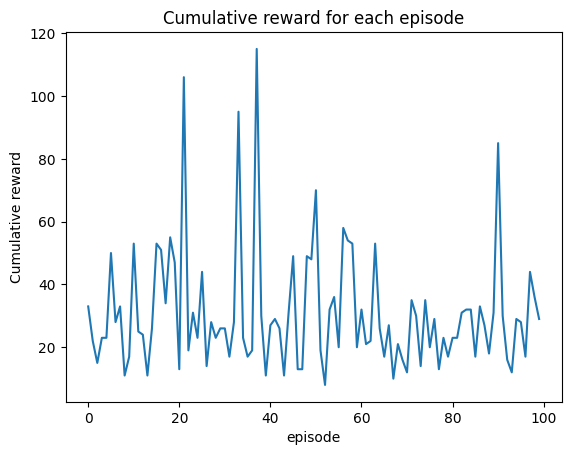

In [191]:
#when alpha=0.1
testing_result = np.array(testing_result)
plt.plot(testing_result)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [192]:
print("Average cumulative reward:", testing_result.mean())
print("Is my agent good enough?", testing_result.mean() > 195)

Average cumulative reward: 30.74
Is my agent good enough? False


when alpha = 0.5

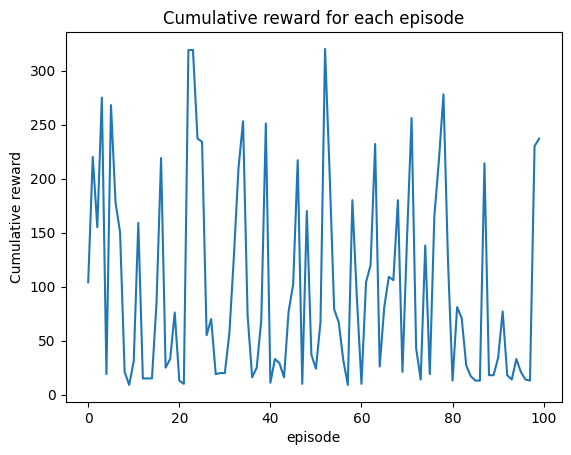

In [206]:
testing_result = np.array(testing_result)
plt.plot(testing_result)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [207]:
print("Average cumulative reward:", testing_result.mean())
print("Is my agent good enough?", testing_result.mean() > 195)

Average cumulative reward: 98.09
Is my agent good enough? False


when alpha = 0.3 , min_epsilon = 0.1 instead of 0.01

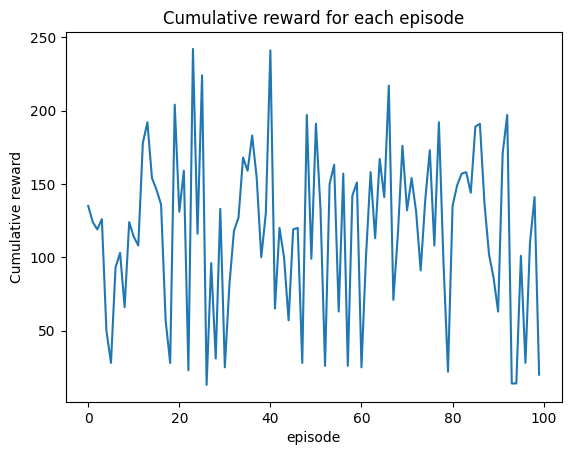

Average cumulative reward: 118.77
Is my agent good enough? False


In [215]:
testing_result = np.array(testing_result)
plt.plot(testing_result)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", testing_result.mean())
print("Is my agent good enough?", testing_result.mean() > 195)

when alpha = 0.3 , min_epsilon = 0.1 instead of 0.01, no_episode = 15k

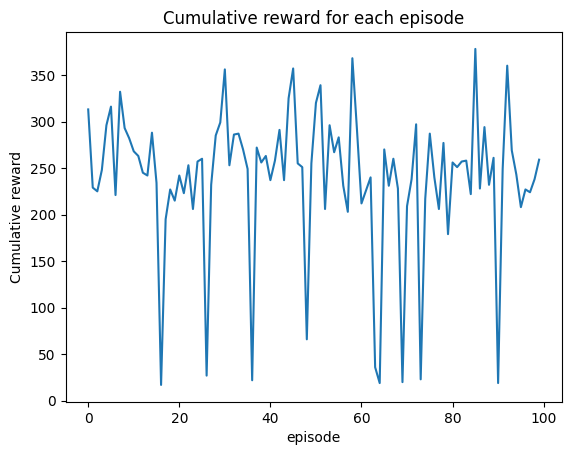

Average cumulative reward: 239.32
Is my agent good enough? True


In [220]:
testing_result = np.array(testing_result)
plt.plot(testing_result)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

print("Average cumulative reward:", testing_result.mean())
print("Is my agent good enough?", testing_result.mean() > 195)

## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [232]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
observation = get_discrete_state(observation)
rewards= 0
while True:
    env.render()
    #your agent goes here
    #print(f"Type of observation: {type(observation)}")
    action = choose_action_trained(observation)

    new_observation, reward, done, info = env.step(action)
    new_observation = get_discrete_state(new_observation)
    observation = new_observation
    rewards+=reward
    if done:
      break;
print(rewards)
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


268.0


In [ ]:
#saving test 1


In [ ]:
#saving test 2